# Graph accuracy vs. confidence

Graph model accuracy vs. confidence; precision-recall curve

In [2]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('../')

In [3]:
"""
INITIALIZATION
"""

import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from bms.evaluate import SmilesEvaluator, convert_smiles_to_canonsmiles


class Args:
    gold_file_syn = [#"../data/molbank/pubchem/test_5k.csv",
                 # "../data/molbank/pubchem/test_chemdraw_5k.csv",
                 "../data/molbank/uspto_test/uspto_indigo.csv",
                 "../data/molbank/uspto_test/uspto_chemdraw.csv"
                ]
    gold_file_real = ['../data/molbank/Img2Mol/CLEF.csv',
                 # '../data/molbank/Img2Mol/JPO.csv',
                 '../data/molbank/Img2Mol/UOB.csv',
                 '../data/molbank/Img2Mol/USPTO.csv',
                 '../data/molbank/Img2Mol/staker.csv',
                 '../data/molbank/acs/acs-331.csv'
                ]
    pred_file_syn = [#"../output/pubchem/synthetic/swin_base_200k_joint/prediction_test_5k.csv",
                 # "../output/pubchem/synthetic/swin_base_200k_joint/prediction_test_chemdraw_5k.csv",
                 "../output/pubchem/synthetic/swin_base_200k_joint/prediction_uspto_indigo.csv",
                 "../output/pubchem/synthetic/swin_base_200k_joint/prediction_uspto_chemdraw.csv"
                 ]
    pred_file_real = ['../output/uspto/swin_base_aux_200k_char_aug_b256/prediction_CLEF.csv',
                 # '../output/uspto/swin_base_aux_200k_char_aug_b256/prediction_JPO.csv',
                 '../output/uspto/swin_base_aux_200k_char_aug_b256/prediction_UOB.csv',
                 '../output/uspto/swin_base_aux_200k_char_aug_b256/prediction_USPTO.csv',
                 '../output/uspto/swin_base_aux_200k_char_aug_b256/prediction_staker.csv',
                 '../output/uspto/swin_base_aux_200k_char_aug_b256/prediction_acs-331.csv'
                ]
    pred_field = "post_SMILES"
    acc_metric = "canon_smiles"
    score_field = "SMILES_score"
    dataset_idx = None
    # low = 0.
    # high = 1.
    # step = 0.05
    zorder = 2
    prc_jump = window_jump = 1

def initialize(extra_args=None, data_type="real", reinit=True):
    global args, gold_df, pred_df
    args = Args()
    if extra_args is not None:
        args.__dict__.update(extra_args)
    if reinit:
        gold_dfs = []
        pred_dfs = []
        gold_file = args.gold_file_real if data_type == "real" else args.gold_file_syn
        pred_file = args.pred_file_real if data_type == "real" else args.pred_file_syn
        total_so_far = 0
        for i, (gdf_path, pdf_path) in enumerate(zip(gold_file, pred_file)):
            if args.dataset_idx is not None and i not in args.dataset_idx:
                continue
            gold_df = pd.read_csv(gdf_path)
            pred_df = pd.read_csv(pdf_path)
            if len(pred_df) != len(gold_df):
                print(f"Pred ({len(pred_df)}) and Gold ({len(gold_df)}) have different lengths!")
                # exit()
            image2goldidx = {image_id: idx for idx, image_id in enumerate(gold_df['image_id'])}
            image2predidx = {image_id: idx for idx, image_id in enumerate(pred_df['image_id'])}
            for image_id in gold_df['image_id']:
                if image_id not in image2predidx:
                    pred_df = pred_df.append({'image_id': image_id, args.pred_field: ""}, ignore_index=True)
            image2predidx = {image_id: idx for idx, image_id in enumerate(pred_df['image_id'])}
            pred_df = pred_df.reindex([image2predidx[image_id] for image_id in gold_df['image_id']])
            gold_df = gold_df.reindex([image2goldidx[image_id] for image_id in gold_df['image_id']])
            pred_df['new_idx'] = range(total_so_far, total_so_far+len(pred_df))
            gold_df['new_idx'] = range(total_so_far, total_so_far+len(pred_df))
            gold_df = gold_df.set_index('new_idx')
            pred_df = pred_df.set_index('new_idx')
            gold_dfs.append(gold_df)
            pred_dfs.append(pred_df)
            total_so_far += len(pred_df)

        gold_df = pd.concat(gold_dfs)
        pred_df = pd.concat(pred_dfs)

def compute_score(rows, field):
    if field in rows.index:
        return rows[field]
    if field == "SMILES_score":
        return rows[field]
    elif field == "edges_prod":
        return np.prod(np.array(eval(row["edges_token_scores"])))
    elif field == "twice_num_edges":
        return np.sum(np.array(eval(row["edges"])).astype(bool))
    elif field == "edges_score":
        return compute_score(row, "edges_prod") ** (1 / max(1, compute_score(row, "twice_num_edges")))
    elif field == "with_edges_score":
        score = row["SMILES_score"] * compute_score(row, "edges_score")
        try:
            assert abs(score - row["with_edges_score"]) < 1e-8
        except AssertionError:
            print(score, row["with_edges_score"])
        return row["with_edges_score"]
    elif field == "with_edges_prod":
        return row["SMILES_score"] * compute_score(row, "edges_prod")
    elif field == "atoms_score":
        token_scores = np.array(eval(row["SMILES_token_scores"]))
        indices = np.array(eval(row["indices"])) - 3
        return np.prod(token_scores[indices]) ** (1 / len(indices))
    elif field == "atoms_with_edges_score":
        return compute_score(row, "atoms_score") * compute_score(row, "edges_score")
    elif field == "atoms_with_edges_prod":
        return compute_score(row, "atoms_score") * compute_score(row, "edges_prod")
        

5it [00:26,  5.25s/it]


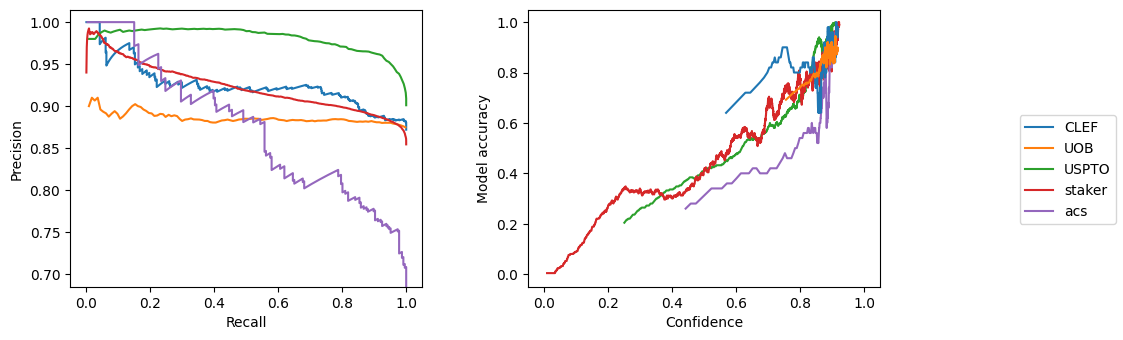

In [8]:
"""
DRAW MODEL ACCURACY VS. CONFIDENCE (PDF) ALONG WITH PRECISION-RECALL CURVE
"""

# data_type = "syn"
# extra_args_list = [{"dataset_idx": [0], "score_field": "with_edges_prod"},
#                    {"dataset_idx": [1], "score_field": "with_edges_prod"}
#                   ]
# legend_names = ["Indigo", "ChemDraw"]
# indices = None
# # indices = [1]  # only plot subset of extra_args_list
# save_fig = "figures/conf_prc_syn_twbp_50_sep.pdf"

data_type = "real"
extra_args_list = [{"dataset_idx": [0], "score_field": "with_edges_prod", "prc_jump": 1, "window": 50, "zorder": 2.1},
                   {"dataset_idx": [1], "score_field": "with_edges_prod", "prc_jump": 50, "window": 250, "zorder": 2.2},
                   {"dataset_idx": [2], "score_field": "with_edges_prod", "prc_jump": 50, "window": 250},
                   {"dataset_idx": [3], "score_field": "with_edges_prod", "prc_jump": 50, "window": 250},
                   {"dataset_idx": [4], "score_field": "with_edges_prod", "prc_jump": 1, "window": 50}
                  ]
legend_names = ["CLEF", "UOB", "USPTO", "staker", "acs"]
indices = None
# indices = [1]  # only plot subset of extra_args_list
save_fig = "figures/conf_prc_real_twbp_j50-1_w250-50_sep.pdf"

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12., 3.6))
fig.subplots_adjust(right=0.8, wspace=0.3)
ax1.set_xlabel("Recall")
ax1.set_ylabel("Precision")
ax1.set_xlim([-0.05, 1.05])
ax1.set_ylim([0.685, 1.015])
ax2.set_ylabel(f"Model accuracy")
ax2.set_xlim([-0.05, 1.05])
ax2.set_ylim([-0.05, 1.05])
ax2.set_xlabel("Confidence")
labels = []
reinit = not all(extra_args.get("dataset_idx") == extra_args_list[0].get("dataset_idx") for extra_args in extra_args_list)
for i, extra_args in tqdm(enumerate(extra_args_list)):
    if indices is not None and i not in indices:
        continue
    initialize(extra_args, data_type, reinit=(i == 0) or reinit)
    assert len(pred_df) == len(gold_df)
    total_len = len(pred_df)
    pred_df = pred_df.sort_values(args.score_field, ascending=False)
    gold_df = gold_df.reindex(index=pred_df.index)
    conf = pred_df[args.score_field]
    evaluator = SmilesEvaluator(gold_df['SMILES'])
    results = evaluator.evaluate(pred_df[args.pred_field], include_details=True)[args.acc_metric+'_details']
    
    # plot precision-recall curve
    cum_correct = np.cumsum(results)
    precision = cum_correct / np.arange(1, len(results)+1)
    tot_correct = np.sum(results)
    recall = cum_correct / tot_correct
    ax1.plot(recall[args.prc_jump-1::args.prc_jump], precision[args.prc_jump-1::args.prc_jump], label=legend_names[i])

    # plot model accuracy vs. confidence
    high_correct = cum_correct[args.window-1:]
    low_correct = np.concatenate(([0.], cum_correct[:-args.window]))
    intvl_correct = high_correct - low_correct
    acc = intvl_correct / args.window
    cum_conf = np.cumsum(list(conf))
    high_conf = cum_conf[args.window-1:]
    low_conf = np.concatenate(([0.], cum_conf[:-args.window]))
    intvl_conf = high_conf - low_conf
    plot_conf = intvl_conf / args.window
    labels.append(ax2.plot(plot_conf[::args.window_jump], acc[::args.window_jump], color=f'C{i}', zorder=args.zorder)[0])

fig.legend(labels, legend_names, loc=7)

plt.savefig(save_fig)